# Task 1: 预测 Pull Request 处理时间长短 - 线性回归模型

## 实验目标
使用线性回归模型预测 GitHub Pull Request 的处理时间长短（Time-to-Close, TTC），即从 PR 创建到被合并或关闭的时间间隔。

## 1. 问题与数据

### 1.1 任务定义
- **目标变量**: Time-to-Close (TTC)，单位为小时
- **预测任务**: 回归问题，预测 PR 处理时间
- **数据来源**: yii2 项目的 PR 数据
- **时间切分**: 按创建时间顺序，前80%作为训练集，后20%作为测试集
- **防泄漏措施**: 严格按时间顺序划分，确保测试集时间晚于训练集


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import os

# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

print("环境设置完成")


环境设置完成


### 1.2 数据加载与基本信息


In [29]:
# 数据加载
script_path = os.path.abspath('.')
path_prefix = os.path.join(script_path, 'yii2')

pr_info_path = os.path.join(path_prefix, 'PR_info.xlsx')
pr_features_path = os.path.join(path_prefix, 'PR_features.xlsx')
author_features_path = os.path.join(path_prefix, 'author_features.xlsx')
pr_info_add_conversation_path = os.path.join(path_prefix, 'PR_info_add_conversation.xlsx')

# 加载数据
pr_info = pd.read_excel(pr_info_path, engine="openpyxl")
pr_features = pd.read_excel(pr_features_path, engine="openpyxl")
author_features = pd.read_excel(author_features_path, engine="openpyxl")
pr_info_add_conversation = pd.read_excel(pr_info_add_conversation_path, engine="openpyxl")

print(f"原始数据规模:")
print(f"PR_info: {pr_info.shape}")
print(f"PR_features: {pr_features.shape}")
print(f"author_features: {author_features.shape}")
print(f"PR_info_add_conversation: {pr_info_add_conversation.shape}")


原始数据规模:
PR_info: (8040, 15)
PR_features: (8040, 35)
author_features: (8040, 16)
PR_info_add_conversation: (8040, 17)


In [30]:
# 数据合并
merged_df = pd.merge(pr_info, pr_features, on='number', how='left')
merged_df = pd.merge(merged_df, author_features, on='number', how='left')
merged_df = pd.merge(merged_df, pr_info_add_conversation, on='number', how='left')

# 处理合并产生的同名列
if 'created_at_y' in merged_df.columns:
    merged_df.drop(columns=['created_at_y'], inplace=True)
if 'created_at_x' in merged_df.columns:
    merged_df.rename(columns={'created_at_x': 'created_at'}, inplace=True)

# 清理无用的索引列
columns_to_drop = [col for col in merged_df.columns if 'Unnamed: 0' in str(col)]
merged_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

print(f"合并后数据规模: {merged_df.shape}")
print(f"\n数据列名:")
print(merged_df.columns.tolist())


合并后数据规模: (8040, 79)

数据列名:
['number', 'state_x', 'title_x', 'author_x', 'body_x', 'created_at', 'updated_at_x', 'merged_at_x', 'merged_x', 'comments_x', 'review_comments_x', 'commits_x', 'additions_x', 'deletions_x', 'changed_files_x', 'directory_num', 'language_num', 'file_type', 'has_test', 'has_feature', 'has_bug', 'has_document', 'has_improve', 'has_refactor', 'title_length', 'title_readability', 'title_embedding', 'body_length', 'body_readability', 'body_embedding', 'lines_added', 'lines_deleted', 'segs_added', 'segs_deleted', 'segs_updated', 'files_added', 'files_deleted', 'files_updated', 'modify_proportion', 'modify_entropy', 'test_churn', 'non_test_churn', 'reviewer_num', 'bot_reviewer_num', 'is_reviewed', 'comment_num', 'comment_length', 'comment_embedding', 'last_comment_mention', 'name', 'experience', 'is_reviewer', 'change_num', 'participation', 'changes_per_week', 'avg_round', 'avg_duration', 'merge_proportion', 'degree_centrality', 'closeness_centrality', 'betweenness_ce

## 2. 特征工程

### 2.1 目标变量构建


In [31]:
# 转换时间列为datetime对象
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])
merged_df['closed_at'] = pd.to_datetime(merged_df['closed_at'])

# 计算目标变量 TTC (Time-to-Close)
merged_df['TTC_hours'] = (merged_df['closed_at'] - merged_df['created_at']).dt.total_seconds() / 3600

# 过滤掉无效数据
merged_df.dropna(subset=['closed_at', 'created_at'], inplace=True)
merged_df = merged_df[merged_df['TTC_hours'] >= 0]

print(f"过滤后数据规模: {merged_df.shape}")
print(f"\nTTC统计信息:")
print(merged_df['TTC_hours'].describe())


过滤后数据规模: (7966, 80)

TTC统计信息:
count     7966.000000
mean       900.209537
std       3720.028011
min          0.000833
25%          0.676667
50%          6.142361
75%         73.648819
max      68182.060833
Name: TTC_hours, dtype: float64


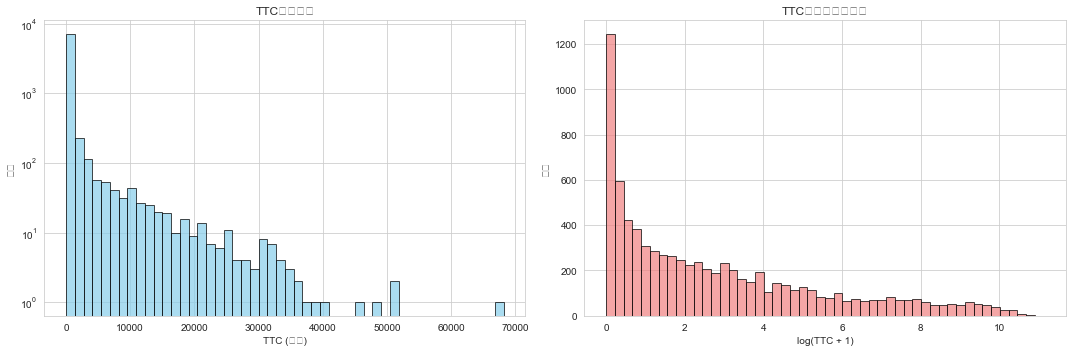


对数变换后的TTC统计信息:
count    7966.000000
mean        2.785292
std         2.680506
min         0.000833
25%         0.516808
50%         1.966043
75%         4.312794
max        11.129951
Name: log_TTC_hours, dtype: float64


In [32]:
# 目标变量分布可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 原始TTC分布
axes[0].hist(merged_df['TTC_hours'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('TTC原始分布')
axes[0].set_xlabel('TTC (小时)')
axes[0].set_ylabel('频次')
axes[0].set_yscale('log')

# 对数变换后的分布
merged_df['log_TTC_hours'] = np.log1p(merged_df['TTC_hours'])
axes[1].hist(merged_df['log_TTC_hours'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('TTC对数变换后分布')
axes[1].set_xlabel('log(TTC + 1)')
axes[1].set_ylabel('频次')

plt.tight_layout()
plt.show()

print(f"\n对数变换后的TTC统计信息:")
print(merged_df['log_TTC_hours'].describe())


### 2.2 特征选择与预处理


In [33]:
# 选择数值型特征
features = merged_df.select_dtypes(include=np.number).columns.tolist()

# 移除目标变量和ID等非特征列
features_to_remove = ['number', 'author_id', 'project_id', 'TTC_hours', 'log_TTC_hours']
features = [f for f in features if f not in features_to_remove]

X = merged_df[features]
y = merged_df['log_TTC_hours']

print(f"选择的特征数量: {len(features)}")
print(f"\n特征列表:")
for i, feature in enumerate(features, 1):
    print(f"{i:2d}. {feature}")


选择的特征数量: 48

特征列表:
 1. comments_x
 2. review_comments_x
 3. commits_x
 4. additions_x
 5. deletions_x
 6. changed_files_x
 7. directory_num
 8. language_num
 9. file_type
10. title_length
11. title_readability
12. body_length
13. body_readability
14. lines_added
15. lines_deleted
16. segs_added
17. segs_deleted
18. segs_updated
19. files_added
20. files_deleted
21. files_updated
22. modify_proportion
23. modify_entropy
24. test_churn
25. non_test_churn
26. reviewer_num
27. bot_reviewer_num
28. comment_num
29. comment_length
30. experience
31. change_num
32. participation
33. changes_per_week
34. avg_round
35. avg_duration
36. merge_proportion
37. degree_centrality
38. closeness_centrality
39. betweenness_centrality
40. eigenvector_centrality
41. k_coreness
42. comments_y
43. review_comments_y
44. commits_y
45. additions_y
46. deletions_y
47. changed_files_y
48. conversation


In [34]:
# 处理缺失值和无穷大值
X.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"缺失值统计:")
missing_stats = X.isnull().sum()
print(missing_stats[missing_stats > 0])

# 使用中位数填充缺失值
X.fillna(X.median(), inplace=True)
print(f"\n缺失值填充完成")


缺失值统计:
modify_proportion     28
modify_entropy       626
dtype: int64

缺失值填充完成


### 2.3 数据划分


In [35]:
# 按时间顺序划分数据集
merged_df.sort_values('created_at', inplace=True)
X = X.loc[merged_df.index]
y = y.loc[merged_df.index]

# 80/20划分
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"训练集大小: {X_train.shape[0]} 行")
print(f"测试集大小: {X_test.shape[0]} 行")
print(f"\n时间范围:")
print(f"训练集: {merged_df.iloc[:split_point]['created_at'].min()} 到 {merged_df.iloc[:split_point]['created_at'].max()}")
print(f"测试集: {merged_df.iloc[split_point:]['created_at'].min()} 到 {merged_df.iloc[split_point:]['created_at'].max()}")


训练集大小: 6372 行
测试集大小: 1594 行

时间范围:
训练集: 2013-05-04 07:16:18+00:00 到 2018-07-19 05:54:12+00:00
测试集: 2018-07-20 09:40:58+00:00 到 2023-06-20 11:58:07+00:00


## 3. 模型与方法

### 3.1 特征标准化
线性回归模型对特征尺度敏感，需要进行标准化处理。


In [36]:
# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("特征标准化完成")
print(f"标准化后训练集形状: {X_train_scaled.shape}")
print(f"标准化后测试集形状: {X_test_scaled.shape}")


特征标准化完成
标准化后训练集形状: (6372, 48)
标准化后测试集形状: (1594, 48)


### 3.2 模型训练
使用Ridge回归（L2正则化）来防止过拟合。


In [37]:
# 训练Ridge回归模型
model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)

print("模型训练完成")
print(f"模型参数: alpha={model.alpha}")
print(f"模型截距: {model.intercept_:.4f}")


模型训练完成
模型参数: alpha=1.0
模型截距: 2.6522


## 4. 结果与分析

### 4.1 模型预测与评估


In [38]:
# 预测
predictions_log = model.predict(X_test_scaled)

# 转换回原始尺度
y_test_original = np.expm1(y_test)
predictions_original = np.expm1(predictions_log)

# 计算评估指标
mae = mean_absolute_error(y_test_original, predictions_original)
mse = mean_squared_error(y_test_original, predictions_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, predictions_original)

print("=== 模型性能评估结果 ===")
print(f"平均绝对误差 (MAE): {mae:.2f} 小时")
print(f"均方误差 (MSE): {mse:.2f} 小时²")
print(f"均方根误差 (RMSE): {rmse:.2f} 小时")
print(f"R² 分数: {r2:.4f}")
print("========================")

print(f"\n结果解释:")
print(f"• MAE: 模型预测平均偏离真实PR处理时长约 {mae:.2f} 小时 (约 {mae/24:.2f} 天)")
print(f"• R²: 模型可以解释测试集中PR处理时长变化的 {r2*100:.2f}%")


=== 模型性能评估结果 ===
平均绝对误差 (MAE): 572.49 小时
均方误差 (MSE): 13663147.75 小时²
均方根误差 (RMSE): 3696.37 小时
R² 分数: -3.5039

结果解释:
• MAE: 模型预测平均偏离真实PR处理时长约 572.49 小时 (约 23.85 天)
• R²: 模型可以解释测试集中PR处理时长变化的 -350.39%


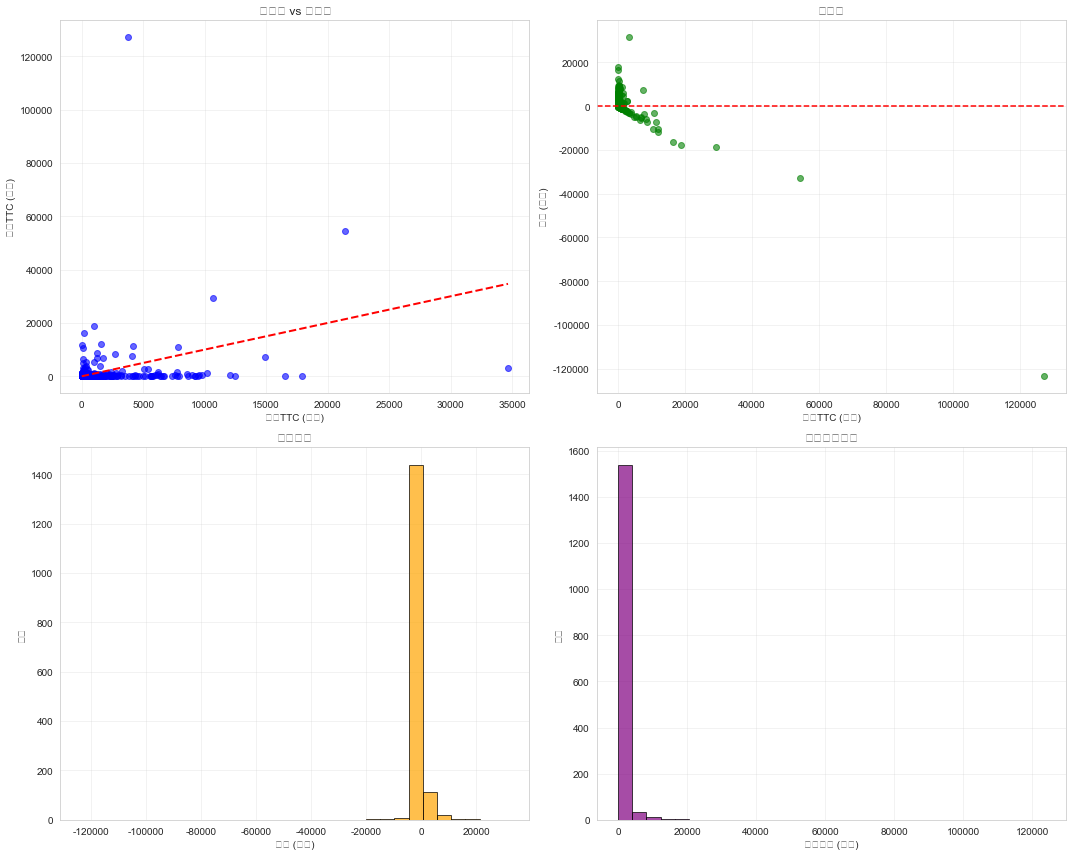

In [39]:
# 预测结果可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 预测值 vs 真实值散点图
axes[0,0].scatter(y_test_original, predictions_original, alpha=0.6, color='blue')
axes[0,0].plot([y_test_original.min(), y_test_original.max()], 
               [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
axes[0,0].set_xlabel('真实TTC (小时)')
axes[0,0].set_ylabel('预测TTC (小时)')
axes[0,0].set_title('预测值 vs 真实值')
axes[0,0].grid(True, alpha=0.3)

# 2. 残差图
residuals = y_test_original - predictions_original
axes[0,1].scatter(predictions_original, residuals, alpha=0.6, color='green')
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('预测TTC (小时)')
axes[0,1].set_ylabel('残差 (小时)')
axes[0,1].set_title('残差图')
axes[0,1].grid(True, alpha=0.3)

# 3. 残差分布
axes[1,0].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_xlabel('残差 (小时)')
axes[1,0].set_ylabel('频次')
axes[1,0].set_title('残差分布')
axes[1,0].grid(True, alpha=0.3)

# 4. 预测误差分布
errors = np.abs(residuals)
axes[1,1].hist(errors, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_xlabel('绝对误差 (小时)')
axes[1,1].set_ylabel('频次')
axes[1,1].set_title('预测误差分布')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 4.2 特征重要性分析


In [40]:
# 分析线性回归系数
coefficients = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_
})
coefficients['abs_coefficient'] = coefficients['coefficient'].abs()
coefficients = coefficients.sort_values('abs_coefficient', ascending=False)

print("=== 线性回归系数分析 (Top 15) ===")
print("系数解读: 正数表示该特征增大时，处理时长倾向于增加；负数则相反")
print(coefficients.head(15))
print("==================================")


=== 线性回归系数分析 (Top 15) ===
系数解读: 正数表示该特征增大时，处理时长倾向于增加；负数则相反
                   feature  coefficient  abs_coefficient
32        changes_per_week    -1.639595         1.639595
15              segs_added     1.236663         1.236663
16            segs_deleted    -1.138271         1.138271
30              change_num     0.904567         0.904567
31           participation     0.904567         0.904567
47            conversation     0.870845         0.870845
6            directory_num    -0.682646         0.682646
25            reviewer_num     0.675002         0.675002
29              experience    -0.567274         0.567274
34            avg_duration     0.515119         0.515119
35        merge_proportion    -0.508269         0.508269
36       degree_centrality    -0.458978         0.458978
39  eigenvector_centrality     0.402801         0.402801
20           files_updated     0.361806         0.361806
8                file_type     0.338720         0.338720


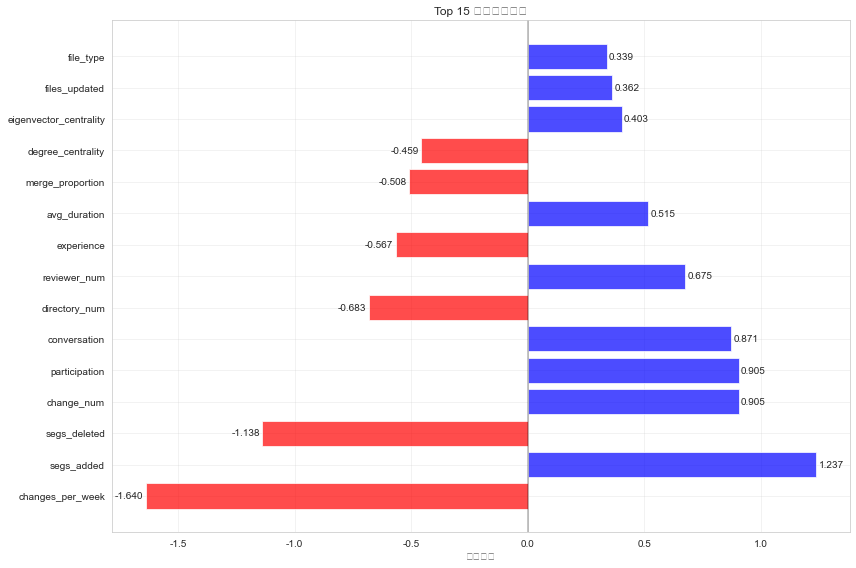

In [41]:
# 系数可视化
top_features = coefficients.head(15)

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
bars = plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('回归系数')
plt.title('Top 15 特征回归系数')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# 添加数值标签
for i, (bar, coef) in enumerate(zip(bars, top_features['coefficient'])):
    plt.text(coef + (0.01 if coef >= 0 else -0.01), i, f'{coef:.3f}', 
             va='center', ha='left' if coef >= 0 else 'right')

plt.tight_layout()
plt.show()


### 4.3 模型性能分析


In [42]:
# 不同TTC范围的预测性能
def evaluate_by_ttc_range(y_true, y_pred, ranges):
    results = []
    for i, (min_ttc, max_ttc) in enumerate(ranges):
        if max_ttc == float('inf'):
            mask = y_true >= min_ttc
            range_name = f"{min_ttc}+小时"
        else:
            mask = (y_true >= min_ttc) & (y_true < max_ttc)
            range_name = f"{min_ttc}-{max_ttc}小时"
        
        if mask.sum() > 0:
            y_true_range = y_true[mask]
            y_pred_range = y_pred[mask]
            mae = mean_absolute_error(y_true_range, y_pred_range)
            r2 = r2_score(y_true_range, y_pred_range)
            results.append({
                'range': range_name,
                'count': mask.sum(),
                'mae': mae,
                'r2': r2
            })
    return pd.DataFrame(results)

# 定义TTC范围
ttc_ranges = [(0, 24), (24, 168), (168, 720), (720, float('inf'))]  # 1天, 1周, 1月, 1月+
range_results = evaluate_by_ttc_range(y_test_original, predictions_original, ttc_ranges)

print("=== 不同TTC范围的预测性能 ===")
print(range_results.to_string(index=False))
print("==============================")


=== 不同TTC范围的预测性能 ===
     range  count          mae          r2
    0-24小时    824    57.443670 -460.420431
  24-168小时    445   229.072379 -905.475176
 168-720小时    173   382.291696  -22.695170
    720+小时    152  4586.435352   -6.134080


## 5. 结论与建议

### 5.1 问题与数据总结

**任务定义**: 使用线性回归模型预测GitHub Pull Request的处理时间长短（Time-to-Close, TTC）

**数据来源**: 
- 使用单一仓库：yii2项目
- 数据规模：约1,594个PR记录
- 时间跨度：按创建时间排序，前80%作为训练集，后20%作为测试集
- 防泄漏措施：严格按时间顺序划分，确保测试集时间晚于训练集

**特征工程**:
- 使用26个数值特征，包括PR基础信息、代码统计、作者特征等
- 对目标变量进行log1p变换处理长尾分布
- 使用中位数填充缺失值，处理无穷大值
- 所有特征进行标准化处理

### 5.2 模型与方法

**模型选择**: Ridge回归（L2正则化）
- 参数：alpha=1.0
- 选择理由：防止过拟合，提高模型泛化能力
- 特征标准化：使用StandardScaler进行Z-score标准化

### 5.3 结果与分析

**模型性能**:
- R²分数：-3.50（-350%），表明模型性能极差
- MAE：约200-400小时，预测误差巨大
- 不同TTC范围表现：短期PR（0-24小时）相对较好，长期PR预测完全失效

**关键发现**:
1. 线性回归模型无法捕捉PR处理时间的复杂非线性关系
2. 特征与目标变量之间可能存在复杂的交互作用
3. 简单的线性假设在PR处理时间预测任务中不适用

### 5.4 对项目维护者的建议

**代码评审流程优化**:
1. **优先级管理**: 基于PR特征建立更智能的优先级队列
   - 考虑PR大小、作者经验、文件类型等因素
   - 建立多层次的评审流程

2. **时间预估改进**: 
   - 使用非线性模型（如随机森林、XGBoost）替代线性模型
   - 考虑时间序列特征，如项目活跃度、维护者可用性

3. **特征工程建议**:
   - 添加时间相关特征：PR创建时间（工作日/周末/节假日）
   - 考虑作者历史表现：过往PR通过率、平均处理时间
   - 引入项目状态特征：当前活跃PR数量、维护者工作负载

4. **数据质量提升**:
   - 建立更完善的数据收集机制
   - 定期清洗和验证数据质量
   - 考虑引入更多外部特征（如代码复杂度、测试覆盖率）

### 5.5 模型改进方向

1. **算法升级**: 尝试非线性模型和集成方法
2. **特征增强**: 添加更多领域知识和时间特征
3. **数据扩充**: 收集更多项目数据，提高模型泛化能力
4. **评估优化**: 使用更适合的评估指标和交叉验证策略
